### Checklist for submission

It is extremely important to make sure that:

1. Everything runs as expected (no bugs when running cells);
2. The output from each cell corresponds to its code (don't change any cell's contents without rerunning it afterwards);
3. All outputs are present (don't delete any of the outputs);
4. Fill in all the places that say `# YOUR CODE HERE`, or "**Your answer:** (fill in here)".
5. Never copy/paste any notebook cells. Inserting new cells is allowed, but it should not be necessary.
6. The notebook contains some hidden metadata which is important during our grading process. **Make sure not to corrupt any of this metadata!** The metadata may for example be corrupted if you copy/paste any notebook cells, or if you perform an unsuccessful git merge / git pull. It may also be pruned completely if using Google Colab, so watch out for this. Searching for "nbgrader" when opening the notebook in a text editor should take you to the important metadata entries.
7. Although we will try our very best to avoid this, it may happen that bugs are found after an assignment is released, and that we will push an updated version of the assignment to GitHub. If this happens, it is important that you update to the new version, while making sure the notebook metadata is properly updated as well. The safest way to make sure nothing gets messed up is to start from scratch on a clean updated version of the notebook, copy/pasting your code from the cells of the previous version into the cells of the new version.
8. If you need to have multiple parallel versions of this notebook, make sure not to move them to another directory.
9. Although not forced to work exclusively in the course `conda` environment, you need to make sure that the notebook will run in that environment, i.e. that you have not added any additional dependencies.

**FOR HA1, HA2, HA3 ONLY:** Failing to meet any of these requirements might lead to either a subtraction of POEs (at best) or a request for resubmission (at worst).

We advise you to perform the following steps before submission to ensure that requirements 1, 2, and 3 are always met: **Restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). This might require a bit of time, so plan ahead for this (and possibly use a cloud GPU in HA1 and HA2 for this step). Finally press the "Save and Checkout" button before handing in, to make sure that all your changes are saved to this .ipynb file.

### Fill in name of notebook file
This might seem silly, but the version check below needs to know the filename of the current notebook, which is not trivial to find out programmatically.

You might want to have several parallel versions of the notebook, and it is fine to rename the notebook as long as it stays in the same directory. **However**, if you do rename it, you also need to update its own filename below:

In [1]:
nb_fname = "HA2-Part2.ipynb"

### Fill in group number and member names (use NAME2 and GROUP only for HA1, HA2 and HA3):

In [2]:
NAME1 = "Bingcheng Chen" 
NAME2 = "Matthieu Michel René Larnouhet"
GROUP = "HA groups 27"

### Check Python version

In [3]:
from platform import python_version_tuple
assert python_version_tuple()[:2] == ('3','9'), "You are not running Python 3.9. Make sure to run Python through the course Conda environment."

### Check that notebook server has access to all required resources, and that notebook has not moved

In [4]:
import os
nb_dirname = os.path.abspath('')
assignment_name = os.path.basename(nb_dirname)
assert assignment_name in ['IHA1', 'IHA2', 'HA1', 'HA2', 'HA3'], \
    '[ERROR] The notebook appears to have been moved from its original directory'

### Verify correct nb_fname

In [5]:
from IPython.display import display, HTML
try:
    display(HTML(r'<script>if("{nb_fname}" != IPython.notebook.notebook_name) {{ alert("You have filled in nb_fname = \"{nb_fname}\", but this does not seem to match the notebook filename \"" + IPython.notebook.notebook_name + "\"."); }}</script>'.format(nb_fname=nb_fname)))
except NameError:
    assert False, 'Make sure to fill in the nb_fname variable above!'

### Verify that your notebook is up-to-date and not corrupted in any way

In [6]:
import sys
sys.path.append('..')
from ha_utils import check_notebook_uptodate_and_not_corrupted
check_notebook_uptodate_and_not_corrupted(nb_dirname, nb_fname)

Matching current notebook against the following URL:
http://raw.githubusercontent.com/dml-cth/deep-machine-learning/master/home-assignments/HA2/HA2-Part2.ipynb
[SUCCESS] No major notebook mismatch found when comparing to latest GitHub version. (There might be minor updates, but even that is the case, submitting your work based on this notebook version would be acceptable.)


# HA2:  Part 2 - Transformers and self-attention
$$
\renewcommand{\vec}[1]{#1}
\def\x{\vec{x}}
\def\y{\vec{y}}
\def\dim{d}
\def\w{W}
\def\wu{Z}
\def\R{\mathbb{R}}
\def\linMap{W}
% Query, key and val
\def\q{\vec{q}}
\def\k{\vec{k}}
\def\v{\vec{v}}
\def\Wq{\linMap_Q}
\def\Wk{\linMap_K}
\def\Wv{\linMap_V}
$$
*You should have completed part 1 before starting with this one*

In this part we will take a closer look at the transformer architecture and the self-attention operation.
We will start with basic self-attention and gradually construct an actual self-attention module.
Finally we will construct a complete transformer and test it on an actual problem.

The focus is on a conceptual understanding of the transformer but you will have to implement a few key elements of a transformer. Along the way we will try to give some best practices for constructing a more complex network architecture.

Let's start with importing the modules we are going to need:

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 1. Basic self-attention

The key-stone of the transformer architecture, self-attention, is a sequence-sequence operation which transforms a sequence of input vectors $\x_1, \dots \x_t$ to output vectors $\y_1, \dots \y_t$.
Remember that all vectors have the same dimension $\dim$, i.e. $\x_i, \y_i \in \R^{\dim}, \forall i = 1, \dots t$.

## Weighted average
The actual transformation is a simple weighted average
$$
\y_i = \sum_{j} \x_j \w_{ji}.
$$

In an actual transformer, weighted averages are computed often and for long sequences. Therefore, the implementation must be fast in order for training to be even possible.
With high-level frameworks such as `pytorch`, the key to fast code is often to reduce loops and instead express computations as matrix operations.

**[3 points]** Complete the function snippet below to implement weighted average.

In this part of the assignment, one point is given for the correct (but not necessarily efficient) implementation; to get one extra point, you must implement it with just a single for loop, and for two extra points, do it without any loops at all.

*Hint*: Take a look at how `torch.bmm` is used later in the implementation

In [12]:
def weighted_avg(x, weights):
    """Weighted average
    Calculates a weighted average of a batch of sequences of vectors.
    
    Args:
        x (torch.Tensor): Shape (batch_size, dim, seq_len)
        
        weights (torch.Tensor): Shape (batch_size, seq_len, seq_len)
    
    Returns:
        y (torch.Tensor): Shape (batch_size, dim, seq_len)
    """
    # YOUR CODE HERE
    y = torch.bmm(x, weights)
    
    return y

Make sure to test your implementation with the unit tests below.
The tests cover:

1. Dimensionality
2. Uniform weights $\w_{ji} = \frac{1}{t}$ should produce $y_i: y_i = \frac{1}{\dim} \sum_{j} x_j,\, \forall i = 1, \dots t$
 (i.e., every $y_i$ is an average of the input sequence).
3. A specific numerical example with batch size = 2, $t = 2,\, \dim=1$.
4. Not breaking gradients.

In [13]:
def test_weighted_avg(function):
    """
    Args:
        function: Implementation to test
    """
    # Testing dimension of averaged tensor.
    batch_size, dim, seq_len = 5, 2, 3
    x = torch.rand(batch_size, dim, seq_len)
    weights = torch.rand(batch_size, seq_len, seq_len)
    y = function(x, weights)
    assert y.shape == (
        batch_size,
        dim,
        seq_len,
    ), "Dimension error: expected y to have shape {}, got {}.".format(
        (batch_size, dim, seq_len), tuple(y.shape)
    )

    # Testing uniform weights preserve x.
    batch_size, dim, seq_len = 5, 2, 3
    x = torch.rand(batch_size, dim, seq_len)
    weights = torch.ones((batch_size, seq_len, seq_len)).float() / seq_len
    y = function(x, weights)
    assert all(
        torch.allclose(y_b.mean(1), y_b[:, 0]) for y_b in y
    ), "Numerical error: With uniform weights, expected y_i = y_j forall i, j (within each batch)."
    assert all(
        torch.allclose(y_b.mean(1), x_b.mean(1)) for (x_b, y_b) in zip(x, y)
    ), "Numerical error: With uniform weights, expected y_i = sum_j x_j, for all i"

    # Actual numerical example.
    x = torch.tensor([4, 1]).reshape((1, 1, 2)).float()
    unnorm_weights = torch.arange(1, 5).reshape((1, 2, 2)).float()
    scale = unnorm_weights.sum(1).reshape((1, 1, 2))
    weights = unnorm_weights / scale

    y = function(x, weights)
    y_true = torch.tensor([7 / 4, 2]).reshape(1, 1, 2).float()
    assert torch.allclose(y, y_true), "Numerical error, expected: {}, got {}".format(
        y_true, y
    )

    x = torch.rand((batch_size, dim, seq_len), requires_grad=True)
    weights = torch.ones((batch_size, seq_len, seq_len), requires_grad=True).float() / seq_len

    try:
        y = function(x, weights)
    except Exception as e:
        print("Error: {}".format(e))
        print("Your function failed to run with the given inputs. Most likely, this is due to breaking gradients.")

    print("Test passed.")


test_weighted_avg(function=weighted_avg)


Test passed.


## Defining weights through the dot product
A simple way to define $\w_{ji}$ is with the dot product

$$
\wu_{ji} = \x_j^T \x_i.
$$
which maps the pair of input vectors to a non-negative scalar, $\R^{\dim \times \dim} \to [0, \infty)$.
We then use a softmax to obtain normalised $\w_{ji} \in (0, 1]$:

$$
\w_{ji} = \frac{ e^{\wu_{ji}} }{ \sum_j e^{\wu_{ji}} }.
$$

**[2 points]** What is the difference between these weights ($W_{ji}$) and the weights in ordinary networks, e.g. a CNN?

**Your answer:**  

1. Self-attention weights are used for capturing relationships between elements within a sequence, it can capture both local and global relationships within a sequence. However, the weights in CNN networks are used for feature transformation, typically operate on local receptive fields. 
2. In self-attention, weights are shared between different positions among the sequence. However, in CNN fully connected layer, weights are not shared between different input positions.

The dot product is essential for calculating the weights. As we progress, we will make slight modifications to the inputs but we will still base it around a function which calculates a softmax-normalized dot product. Therefore, you need to complete the implementation below **[3 points]**:

Again, this function will be evaluated often and for long sequences in the transformer block. For all points, implement it without using for loops.

In [24]:
def normalized_dot_product(v_1, v_2):
    """Normalized dot products between all pairs of vectors in a sequence
    Takes two batches of sequences of vectors as input.
    Sequences in the batch are processed independently.
    The normalization is done with a softmax function along the columns of the weight matrices.
    
    Args:
        v_1 (torch.Tensor): Shape (batch_size, dim, seq_len)
        v_2 (torch.Tensor): Shape (batch_size, dim, seq_len)

    Returns:
        norm_dot_prod (torch.Tensor): Shape (batch_size, seq_len, seq_len)
    """

    # YOUR CODE HERE
    # Compute dot product for all pairs of vectors
    dot_product = torch.bmm(v_1.transpose(1, 2), v_2)

    norm_dot_prod = F.softmax(dot_product, dim=1)

    return norm_dot_prod

Make sure to test your implementation with the unit tests below.
The tests cover:

1. Dimensionality
2. Normalized in the correct dimension
3. A specific numerical example
4. Not breaking gradients.

In [25]:
import numpy as np


def test_normalized_dot_product(function):
    """
    Args:
        function: Implementation to test
    """

    batch_size, dim, seq_len = 5, 2, 3
    v_1 = torch.rand(batch_size, dim, seq_len)
    v_2 = torch.rand(batch_size, dim, seq_len)
    weights = function(v_1, v_2)

    # Testing dimension of weights.
    assert weights.shape == (
        batch_size,
        seq_len,
        seq_len,
    ), "Dimension error: expected weights to have shape {}, got {}.".format(
        (batch_size, seq_len, seq_len), tuple(weights.shape)
    )

    # Testing weights non-negative
    # (Boolean tensor's can be reduced to a single boolean)
    assert not (
        weights < 0.0
    ).any(), "Value error: expected weights to be non-negative."

    # Testing weights smaller than one
    assert (weights < 1.0).all(), "Value error: expected weights to be non-negative."

    assert torch.allclose(
        weights.sum(1), torch.ones((batch_size, seq_len))
    ), "ValueError: expected columns (dim 1) to sum to 1.0"

    # Actual numerical example
    v_1 = torch.tensor([[1, 2], [-1, 1]]).float().reshape((1, 2, 2))
    v_2 = torch.tensor([[1, 0], [1, -1]]).float().reshape((1, 2, 2))
    e = np.exp(1)
    true_weights = (
        torch.tensor(
            [
                [1 / (e ** 3 + 1), e ** 2 / (e ** 2 + 1)],
                [e ** 3 / (e ** 3 + 1), 1 / (e ** 2 + 1)],
            ]
        )
        .float()
        .reshape((1, 2, 2))
    )
    weights = function(v_1, v_2)
    assert torch.allclose(
        true_weights, weights
    ), "Numerical error: expected {}, got {}.".format(true_weights, weights)

    # Testing gradients
    v_1 = torch.rand((batch_size, dim, seq_len), requires_grad=True)
    v_2 = torch.rand((batch_size, dim, seq_len), requires_grad=True)
    try:
        weights = function(v_1, v_2)
    except Exception as e:
        print("Error: {}".format(e))
        print("Your function failed to run with the given inputs. Most likely, this is due to breaking gradients.")

    print("Test passed.")


test_normalized_dot_product(function=normalized_dot_product)


Test passed.


That's it, we have now the building blocks needed for basic self-attention:

In [26]:
def basic_self_attention(x):
    """Basic self-attention
    Transforms a batch of sequences of vectors.
    
    Args:
        x (torch.Tensor): Shape (batch_size, dim, seq_len)
    
    Returns:
        y (torch.Tensor): Shape (batch_size, dim, seq_len)
    """
    weights = normalized_dot_product(x, x)
    return weighted_avg(x, weights)


# 2. A self-attention module
Like you saw in the video lectures, self-attention is rarely used in the basic form we have created above.
Let's do the modifications needed to construct an actual transformer.

We will wrap it in a proper `torch.nn` module to create a building block that we can use in a network.
Creating your own module is actually not that common, frameworks like `pytorch` are built to be *modular* and we can often create very specific networks by combining standard modules. That is a good thing, since it enables us to express interesting models in a high-level interface and as a bonus, we build a model from well-tested and efficient parts.
With that said, you might find yourself in a situation (perhaps already in the project) where no off-the-shelf module suits your need and you have to create one yourself. View this latter part as an example/inspiration of how to construct a non-trivial custom module.

## Queries, keys and values
The self-attention is extended with three linear mappings $\Wq, \Wk, \Wv \in \R^{\dim \times \dim}$ .
These give us learnable parameters and make self-attention more flexible.
The three matrices map the input $\x_i$ into a query, key and value respectively:

\begin{align}
    \q_i = \Wq \x_i \\
    \k_i = \Wk \x_i \\
    \v_i = \Wv \x_i
\end{align}

First, we modify the self-attention by redefining the unnormalized weights (while reusing the notation):

\begin{align}
    \wu_{ji} = \k_j^T \q_i \Big/ \sqrt{\dim}
\end{align}
The normalized weights are still obtained by applying the softmax function.

**[2 points]** Explain why we scale the dot product with the factor $1 / \sqrt{\dim}$.

**Your answer:** 

1. This is because we want to control the magnitude of the dot products to help stabilize the training process.
2. Without scaling the factor $1 / \sqrt{\dim}$, the dot product will have a magnitude that grows with the dimensionality of the vectors. which resulting in gradients in the training process also large, that can make convergence harder.

Finally, the weighted average is modified and is now based on the values $\v_j$, instead of on $\x_j$ directly:
$$
\y_i = \sum_{j} \v_j \w_{ji}.
$$

We can reuse our dot product calculation by simple *wrapping* it in a function that takes queries and keys as the argument:

In [27]:
def query_key_weights(queries, keys):
    """Weights from query-key dot product.
    Softmax-normalised dot product weights
    Calculates weights for a batch of sequences of vectors.
    
    Args:
        queries (torch.Tensor): Shape (batch_size, dim, seq_len)
        keys (torch.Tensor): Shape (batch_size, dim, seq_len)
    
    Returns:
        weights (torch.Tensor): Shape (batch_size, seq_len, seq_len)
    """
    dim = queries.shape[1]
    queries = queries / (dim ** (1 / 4))
    keys = keys / (dim ** (1 / 4))
    return normalized_dot_product(keys, queries)


## Multi-head self-attention

The model should be able to find different patterns in the input sequence, which is why we use multiple heads.

Now, we'll create the actual self-attention function, which includes multiple heads.
For implementation simplicity and efficiency, the input vector is split into parts and each attention head is applied to just one part of the vector.
Imagine that we have $d = 64$ and four heads, then each head would operate on a vector with dimension $64 / 4 = 16$.

## Constructing the module
Below is an implementation of our self-attention module. We try to show you how a typical custom model looks like. Part of that is to do full vectorization (i.e. no loops). The result is a lot of manipulation of shapes and dimension order of intermediate tensors. It might be quite difficult to read and to wrap your head around, but since you are likely to use and modify other peoples code (in the project or some later time), it is good that you get exposed to it now.

We also use a package called ``einops`` which makes it easier to manipulate dimensions of tensors. It is not necessary to use it, but it makes the code a bit more readable. Please run the cell below to install `einops` if you haven't done so already. Also, make sure you have activated the `dml` environment before running the cell.

In [29]:
# !pip install einops

In [30]:
from einops import rearrange


class SelfAttention(nn.Module):
    def __init__(self, dim, heads):
        """Self-attention module

        Args:
            dim (int): The full embedding dimension of the input vectors
            heads (int): The number of heads in the multi-head attention.
        """
        super().__init__()
        if not dim % heads == 0:
            raise ValueError(
                "The embedding dim. must be divisible by the number of heads for the vectorization to work."
            )
        self.dim = dim
        self.heads = heads
        head_dim = dim // heads
        # Linear maps for q, k and v
        self.Wq = nn.Linear(dim, heads * head_dim, bias=False)
        self.Wk = nn.Linear(dim, heads * head_dim, bias=False)
        self.Wv = nn.Linear(dim, heads * head_dim, bias=False)
        # Linear mapping to return to the original
        self.WO = nn.Linear(heads * head_dim, dim)

    def forward(self, x):
        """Multi-headed self attention

        Each head operates on a part of the embedding, i.e. we have q, k and v with shape
        (batch_size, seq_length, heads, dim / heads)
        
        Args:
            x (Tensor): Input with shape (batch_size, seq_length, dim)
        """

        # The input is projected with the three different linear maps
        # and reshaped to combine the batch and head dimensions for efficiency.
        keys = rearrange(self.Wk(x), "b s (h d) -> (b h) d s", h=self.heads)
        queries = rearrange(self.Wq(x), "b s (h d) -> (b h) d s", h=self.heads)
        values = rearrange(self.Wv(x), "b s (h d) -> (b h) d s", h=self.heads)

        # The weights are calculated from the query-key dot product
        weights = query_key_weights(queries, keys)

        # The output is the weighted average of the values
        y_tilde = weighted_avg(values, weights)

        # The output is reshaped to a suitable shape before projected back to the original dimension
        y_tilde = rearrange(y_tilde, "(b h) d s -> b s (h d)", h=self.heads)

        return self.WO(y_tilde), weights


# The transformer block

The majority of the implementation complexity is actually in the `SelfAttention` module. The transformer block is rather straight forward, it is just like the one described in the video lectures:

In [31]:
class TransformerBlock(nn.Module):
    """Transformer block"""

    def __init__(self, dim, heads):
        super().__init__()

        self.self_attention = SelfAttention(dim, heads)

        self.normalization_1 = nn.LayerNorm(dim)
        self.normalization_2 = nn.LayerNorm(dim)

        # The size of the hidden layer is a hyper-parameter,
        # but the consensus is that it should at least be larger than the input/output size
        self.feed_forward = nn.Sequential(
            nn.Linear(dim, 4 * dim), nn.ReLU(), nn.Linear(4 * dim, dim),
        )

    def forward(self, x):
        """Forward pass of Transformer block
        
        Args:
            x (torch.Tensor): Input with shape (batch_size, seq_length, dim)
            
        Returns:
            y (torch.Tensor): Output with shape (batch_size, seq_length, dim)
            attention_weights (torch.Tensor): Weights for the attention layer with shape (batch_size, seq_length, seq_length)
        """
        y, attention_weights = self.self_attention(x)
        # Note how the residual (skip) connections are implemented as simple addition.
        x = self.normalization_1(x + y)
        fed_forward = self.feed_forward(x)
        return self.normalization_2(fed_forward + x), attention_weights


Now, we are done with the general module. To create an actual transformer yet we must choose an actual problem so that we can specify input, embedding and output.
Let's do that.

# 3. IMDB Classification

In this task we will consider classification of IMDB reviews. For pedagogical reasons, the classification will be based upon the functions you have built above. The idea is to clarify the connection between these functions and an application with real data. However, to get better performance, we will rely on a pre-trained NLP model, namely [distill-bert](https://huggingface.co/distilbert-base-uncased) for extracting features and improving performance. This is a smaller version of BERT, a Transformer-based language model that is pretrained on a large corpus and useful for extracting features from text. This is similar to the transfer learning done in HA1 where we utilize powerful, general purpose models for extracting features, and finetune a smaller model for the task at hand.

The purpose here is to build on the computer labs and to give you some inspiration for how to solve a general problem with `pytorch`. It will show you how to install additional python libraries (useful for the project) and some advice on how to construct a training/validation loop. We do not expect you to modify the code, **you don't even have to run the training** if you feel that your cloud credits are starting to run low. However, you should read and understand the code; it will help you answer the questions.

## Installing additional packages
DistilBERT is implemented by an external python module called `transformers` while the IMDB data is provided by `datasets`. Both these can be installed by running the cell below.

Make sure that you have activated the dml environment before your run it.

In [33]:
# !pip install transformers
# !pip install datasets

## The data
Processing text data can be tedious and error prone. For prototyping it is nice to use some third-party library which has done most of the work for you. You do not really need to focus on the data processing here, since it will be different for every task.


In [34]:
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, DataCollatorWithPadding


def load_imdb_dataset(model_name, tokenizer):
    """Loads the IMDB dataset"""

    def preprocess_function(examples):
        return tokenizer(examples["text"], truncation=True)

    imdb = load_dataset("imdb")

    tokenized_imdb = imdb.map(preprocess_function, batched=True)
    return tokenized_imdb


def get_collator(model_name, tokenizer):
    """Returns a collator, which is a function that takes a batch of examples and returns a batch of tensors"""
    return DataCollatorWithPadding(tokenizer=tokenizer)


def get_loaders(batch_size, model_name):
    """Returns data loaders"""
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    dataset = load_imdb_dataset(model_name, tokenizer)
    data_collator = get_collator(model_name, tokenizer)
    dataset.set_format("torch", columns=["input_ids", "label", "attention_mask"])
    train_loader = DataLoader(
        dataset["train"], batch_size=batch_size, shuffle=True, collate_fn=data_collator
    )
    test_loader = DataLoader(
        dataset["test"], batch_size=batch_size, collate_fn=data_collator
    )
    return train_loader, test_loader


We can have a look at different examples from the dataset. The tokenizer has mapped the text to a sequence of integers, `input_ids`. During this mapping, the tokenizer also adds special tokens, such as padding and a class token (`input_id` 101). The class token is often used for sequence-level classification. 

Further we can see that the label is represented as 0 (negative review) or 1 (positive review).

In [35]:
def view_example_text(dataset, index, split="train"):
    """View an example text from the dataset"""
    print(dataset[split]["label"][index])
    print(dataset[split]["text"][index])
    print(dataset[split]["input_ids"][index])
    print()


MODEL_NAME = "distilbert-base-uncased"
imdb = load_imdb_dataset(MODEL_NAME, AutoTokenizer.from_pretrained(MODEL_NAME))
view_example_text(imdb, 1337)


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

0
This film essentially deals with Inspector Gadget's arch-nemesis Doctor Claw who has returned after many years to the now-peaceful city of Metropolis. Claw's plan is to foil Gadget once and for all by using a newer "cooler" crimefighter to help destroy Gadget's popularity. Sadly the film fails miserably, the series was great, but it was revived nearly 20 years later with tragic results. Without the voice of Don Adams as Inspector Gadget it just doesn't cut it anymore; Dr. Claw is not only visually less frightening, but sounds more like a wrestler with a cold, than his original intimidating self. Granted this is a children's movie, but the plot is so painfully weak (heaven forbid I mention the animation) that it pales in comparison to the original series. Someone has decided to updated Penny as well to bring her two decades up to speed, she now has some quasi-punk rebellious clothing style and doesn't play half the role that she did in the TV series. The Gadgetmobile talks, as well as

## The transformer
We will create a simple transformer that takes as input the processed feature vectors from distilBERT and which outputs a probability vector over the two classes "neg" and "pos" (technically, the output will be the input to a log-softmax). The model also outputs the attention weights for visualization later.
We make the simplest (and less memory efficient) version of position embedding as described in the video lectures.

We'll also create a module that holds the pre-trained distilBERT model.

In [36]:
from transformers import AutoModel


class Transformer(nn.Module):
    def __init__(self, in_dim, dim, heads, depth, seq_length, num_classes):
        super().__init__()

        self.input_map = nn.Linear(in_dim, dim)
        self.pos_emb = nn.Embedding(seq_length, dim)
        self.max_seq_length = seq_length

        transformer_blocks = []
        for _ in range(depth):
            transformer_blocks.append(TransformerBlock(dim=dim, heads=heads))

        # A ModuleList is a list of Modules, so you can access intermediate values and it registers part of the model properly.
        # This ensures that all parameters are moved to the correct device when calling Transformer().to(device)
        self.transformer_blocks = nn.ModuleList(transformer_blocks)

        # The last part is problem specific. Here we want to map our transformer embeddings
        # to a probability distribution.
        # We will use a linear layer to produce logits (the input to a log-softmax function).
        self.output_map = nn.Linear(dim, num_classes)

    def forward(self, x):
        """Transformer forward method

        Args:
            x Tensor(batch_size, seq_length, in_dim): Input tensor
        Returns:
            Tensor(batch_size, num_classes): Logits
            Tensor(batch_size*num_heads, seq_length, seq_length): Attention weights
        """
        x = self.input_map(x)
        batch_size, seq_length, dim = x.shape
        if seq_length > self.max_seq_length:
            x = x[:, : self.seq_length]

        # Note that we create a completely new tensor which must be moved to the proper device.
        pos = torch.arange(seq_length, device=x.device)
        # Unsqueeze to add the batch dimension, same as [None, ...]
        pos = self.pos_emb(pos).unsqueeze(0)
        x = x + pos

        attention_weights = []

        for i, block in enumerate(self.transformer_blocks):
            x, attention_weight = block(x)
            attention_weights.append(attention_weight.unsqueeze(1))

        # Use [CLS] token for classification
        x = self.output_map(x[:, 0, :])
        return F.log_softmax(x, dim=1), torch.cat(attention_weights, dim=1)


class BERTEncoder(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased"):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.output_size = self.bert.config.hidden_size

    def forward(self, input_ids, attention_mask):
        """Forward pass of BERT encoder
        
        Args:
            input_ids (torch.Tensor): Input with shape (batch_size, seq_length)
            attention_mask (torch.Tensor): Mask with shape (batch_size, seq_length)

        Returns:
            Tensor(batch_size, seq_length, hidden_size): Encoded input
            Tensor(batch_size, num_layers, seq_length, seq_length): Attention weights
        """
        out = self.bert(
            input_ids=input_ids, attention_mask=attention_mask, output_attentions=True
        )
        return out.last_hidden_state, out.attentions

    def to(self, device):
        self.bert.to(device)
        return self


Let's combine the two modules into a single network. We'll freeze all layers in the pre-trained model and only train our Transformer. 

In [37]:
class ImdbClassifier(nn.Module):
    def __init__(self, dim, heads, depth, seq_length, num_classes, freeze_encoder=True):
        super().__init__()
        self.bert = BERTEncoder()
        if freeze_encoder:
            for param in self.bert.parameters():
                param.requires_grad = False

        self.transformer = Transformer(
            self.bert.output_size, dim, heads, depth, seq_length, num_classes
        )

    def forward(self, input_ids, attention_mask, *args, **kwargs):
        x, bert_attn = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x, transformer_attn = self.transformer(x)
        return (
            x,
            {"bert_attn": torch.cat(bert_attn), "transformer_attn": transformer_attn},
        )

    def to(self, device):
        self.bert.to(device)
        self.transformer.to(device)
        return self



Now, for the train./val loop. This can be written in many ways but based on common misstakes in HA1, hints might be in order:

- Separate your code into smaller pieces, i.e. functions. It makes it easier to find bugs and easier to reuse code.
- Use separate functions to calculate metrics. If you want to calculate, say accuracy, during both training and validation, don't copy the code. Write one function and make sure that it works, then reuse it.
- Adding measurements to a running metrics can be tricky. Below is a solution that is a bit overkill but that is okay, since it is hard to use it incorrectly.

Note: the code below can be modified so that you can play around with it.

In [38]:
from time import time


def train_epoch(model, train_loader, optimizer, scheduler, max_seq_len, device):
    """Train epoch"""
    train_loss = AccumulatingMetric()
    train_acc = AccumulatingMetric()
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        for key, val in batch.items():
            batch[key] = val.to(device)
        label = batch["labels"]
        pred, _ = model(batch["input_ids"], batch["attention_mask"])
        loss = F.nll_loss(pred, label)
        loss.backward()
        train_loss.add(loss.item())

        train_acc.add(accuracy(pred, label))

        optimizer.step()
        scheduler.step()
    return train_loss.avg(), train_acc.avg()


def validate_epoch(model, val_loader, max_seq_len, device):
    """Validate epoch"""
    val_loss = AccumulatingMetric()
    val_acc = AccumulatingMetric()
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            for key, val in batch.items():
                batch[key] = val.to(device)
            label = batch["labels"]
            pred, _ = model(batch["input_ids"], batch["attention_mask"])
            val_loss.add(F.nll_loss(pred, label).item())

            val_acc.add(accuracy(pred, label))

    return val_loss.avg(), val_acc.avg()


def predict_epoch(model, loader, max_seq_len, device):
    """Run prediction"""
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for batch in loader:
            for key, val in batch.items():
                batch[key] = val.to(device)
            label = batch["labels"]
            pred, _ = model(batch["input_ids"], batch["attention_mask"])
            hard_pred = pred.argmax(1)
            preds.append(hard_pred.cpu())
            labels.append(label.cpu())

    return torch.cat(preds), torch.cat(labels)


def accuracy(pred, label):
    hard_pred = pred.argmax(1)
    return (hard_pred == label).float().mean().item()


def _truncate_input(input_, max_seq_len):
    if input_.size(1) > max_seq_len:
        input_ = input_[:, :max_seq_len]
    return input_


class AccumulatingMetric:
    """Accumulate samples of a metric and automatically keep track of the number of samples."""

    def __init__(self):
        self.metric = 0.0
        self.counter = 0

    def add(self, value):
        self.metric += value
        self.counter += 1

    def avg(self):
        return self.metric / self.counter


The code below sets a few hyperparameters and runs the training. If you are having trouble accessing GPUs, feel free to only study the code. We provide a pre-trained model you can load in the next cell.

If you want, feel free to play around with the training, or the model parameters. For reference, the provided checkpoint reaches 91% accuracy on the test data. Also, timing this on Azure, a single epoch took ~12 min. 

**Note**: You have to change the value of `num_epochs`. It is set to 0 initially to avoid training if you run the notebook top to bottom. We trained our model for 5 epochs. 

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

batch_size = 4
train_loader, test_loader = get_loaders(batch_size, MODEL_NAME)


max_length = 512
embedding_size = 128
num_heads = 8
num_classes = 2
depth = 2

model = ImdbClassifier(
    dim=embedding_size,
    heads=num_heads,
    depth=depth,
    seq_length=max_length,
    num_classes=num_classes,
)

model.to(device)

lr = 1e-4
lr_warmup = 1e4
num_epochs = (
    0  # Change this to train for more epochs, we trained our model for 5 epochs
)

optimizer = torch.optim.Adam(lr=lr, params=model.parameters())
# A scheduler is a principled way of controlling (often decreasing) the learning rate as time progresses.
# Read more: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lambda i: min(i / (lr_warmup / batch_size), 1.0)
)

print("Starting training")
for epoch in range(num_epochs):
    start = time()
    train_loss, train_acc = train_epoch(
        model, train_loader, optimizer, scheduler, max_length, device
    )
    val_loss, val_acc = validate_epoch(model, test_loader, max_length, device)
    end = time()
    print(
        "Epoch: {}/{}: time: {:.1f}, train loss: {:.3f}, train acc: {:.3f}, val. loss {:.3f}, val. acc: {:.3f}".format(
            epoch + 1, num_epochs, end - start, train_loss, train_acc, val_loss, val_acc
        )
    )
print("You have now trained a transformer!")

# Save all parameters except for the BERT ones
reduced_state_dict = {}
for key, val in model.state_dict().items():
    if key.startswith("bert"):
        continue
    reduced_state_dict[key] = val
torch.save(reduced_state_dict, "my_model.pt")


Using device: cpu


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Starting training
You have now trained a transformer!


Run the cell below to load the provided checkpoint. **Do not** modify hyperparameters below for loading the provided model. If you have trained your own model, simply skip this cell.

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

batch_size = 4

train_loader, test_loader = get_loaders(batch_size, MODEL_NAME)

max_length = 512
embedding_size = 128
num_heads = 8
num_classes = 2
depth = 2

model = ImdbClassifier(
    dim=embedding_size,
    heads=num_heads,
    depth=depth,
    seq_length=max_length,
    num_classes=num_classes,
)


model.load_state_dict(
    torch.load("model.pt", map_location=torch.device("cpu")), strict=False
)
model.to(device)
model.eval()


Using device: cpu


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

ImdbClassifier(
  (bert): BERTEncoder(
    (bert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (ffn): FFN(
              (dropo

## Analysing the model and self-attention
Self-attention is a key component of the Transformer. Further, the attention weights can offer some insights into the inner workings of the model, e.g., how the attention weights are used to focus on certain parts of the input. They can also highlight how inputs relate to each other. Of course, one cannot draw conclusions about a model from the attention weights alone, but it still interesting to have a look at them.

Below we define some helper functions to visualize the attention weights.

**[2 points]** Why is it that we cannot simply inspect the attention weights $W_{ji}$ and draw conclusion about the inner workings and reasoning of the model?

**Your answer:**   

1. Although some attention weights can provide valuable insights in understanding the model behavior, the attention weights in a model can also be highly complicated which cannot be simply interpreted.
2. Transformers has multiple heads which each head has its own weights, these weights interact in a complex way which involves feedforward network, add & normailize, thus it's not enough to draw conclusion about the inner reasoning of the model just by simply inspect the attention weights $W_{ji}$.

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns


def visualize_attention_one_token(attention_weights, input_, token_name=""):
    """Visualize attention from one token to other tokens for each head."""

    tokens = input_["tokens"]
    num_tokens = len(tokens)

    fig, ax = plt.subplots(figsize=(5, len(tokens) / 5))

    # We remove the padding tokens from the attention weights.
    attention_weights = attention_weights[:, :num_tokens]
    attention_weights = attention_weights.cpu().numpy()

    cmap = sns.heatmap(attention_weights.T, cmap="Reds", yticklabels=tokens)
    plt.title(f"Attention weights for {token_name}")
    plt.xlabel("Head index")
    plt.show()


def visualize_attention_map(attention_weights, input_, title=""):
    """Visualize attention between all tokens."""

    tokens = input_["tokens"]
    num_tokens = len(tokens)

    fig, ax = plt.subplots(figsize=(len(tokens) / 5, len(tokens) / 5))

    # We remove the padding tokens from the attention weights.
    attention_weights = attention_weights[:num_tokens, :num_tokens]
    attention_weights = attention_weights.cpu().numpy()

    cmap = sns.heatmap(
        attention_weights.T, cmap="Reds", yticklabels=tokens, xticklabels=tokens,
    )
    plt.ylabel("Queries")
    plt.xlabel("Keys")
    plt.title(title)
    plt.show()


def create_attention_plots(
    model, input_, lvl_idx=-1, head_idx=0, attn_key="transformer_attn"
):
    """Create attention plots."""
    # Create attention plots for all tokens in input.
    pred, attention_weights = model(input_["input_ids"], input_["attention_mask"])
    attention_weights = attention_weights[attn_key]
    # Visualize attention from CLS token to other tokens for each head.
    if attn_key == "transformer_attn":
        attention_from_cls_token = attention_weights[:, lvl_idx, :, 0]
    elif attn_key == "bert_attn":
        # Bert attention weights are stored in a different format.
        attention_from_cls_token = attention_weights[lvl_idx, :, 0, :]
    else:
        raise ValueError(f"Unknown attention key: {attn_key}")

    visualize_attention_one_token(attention_from_cls_token, input_, "[CLS]")

    # Visualize attention between all tokens.
    if attn_key == "transformer_attn":
        attention_weights_head = attention_weights[head_idx, lvl_idx]
    elif attn_key == "bert_attn":
        # Bert attention weights are stored in a different format.
        attention_weights_head = attention_weights[lvl_idx, head_idx].T
    else:
        raise ValueError(f"Unknown attention key: {attn_key}")

    title = f"Attention weights for head {head_idx}"
    visualize_attention_map(attention_weights_head, input_, title)


def text_to_tensor(text, tokenizer):
    """Convert text to tensor."""
    encoded_input = tokenizer(text, truncation=True)
    return encoded_input


Below we load some of the validation data, send it through the model and visualize the attention weights. The `idx` determines which text from the validation set to use. The `lvl_idx` determines which Transformer block to visualize, 0 corresponds to the first Transformer block, `depth-1` is the last Transformer block. The `head_idx` determines which attention head to visualize.

The first figure shows the attention weights from the class token to all other tokens for all heads in the selected `lvl_idx`. The second figure shows the attention weights between all tokens for the selected `head_idx` in the selected `lvl_idx`. The y-axis corresponds to queries while the x-axis corresponds to keys. For longer sequences, the second figure can be hard to read. 

In [42]:
# We'll need the tokenizer to convert the text into tensors and vice versa.
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


Predicted probabilities: tensor([[0.9950, 0.0050]])


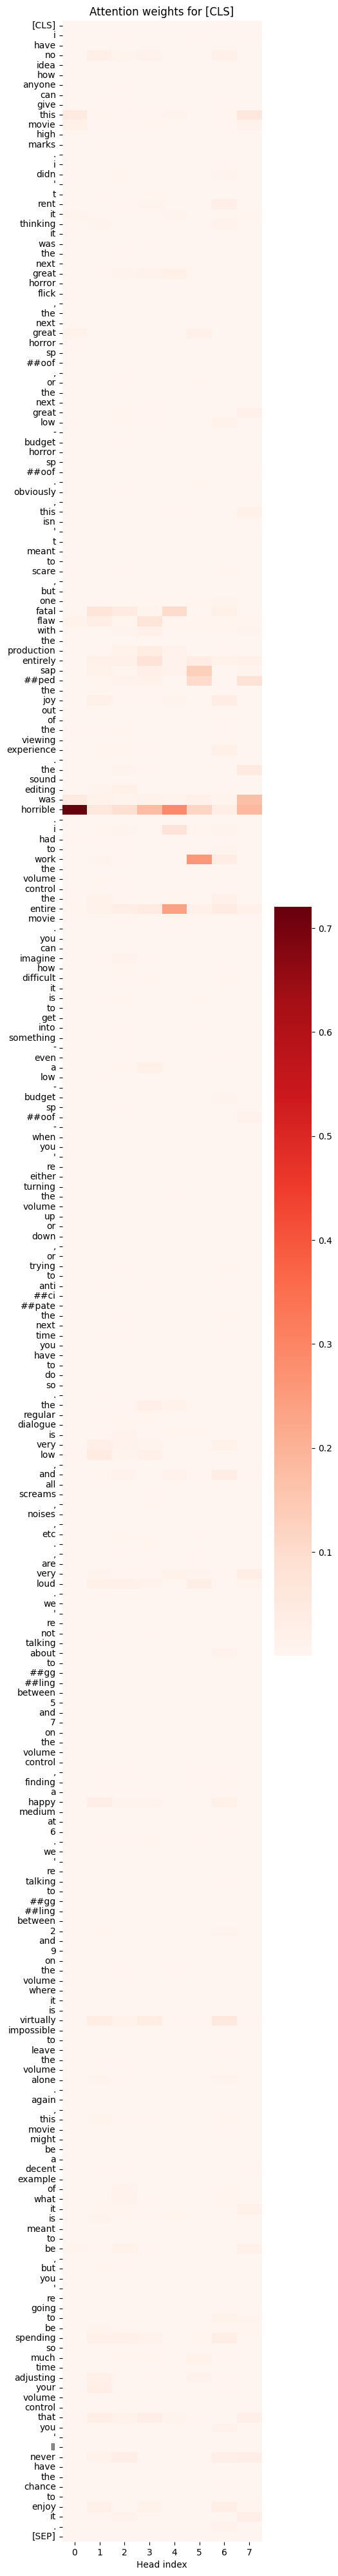

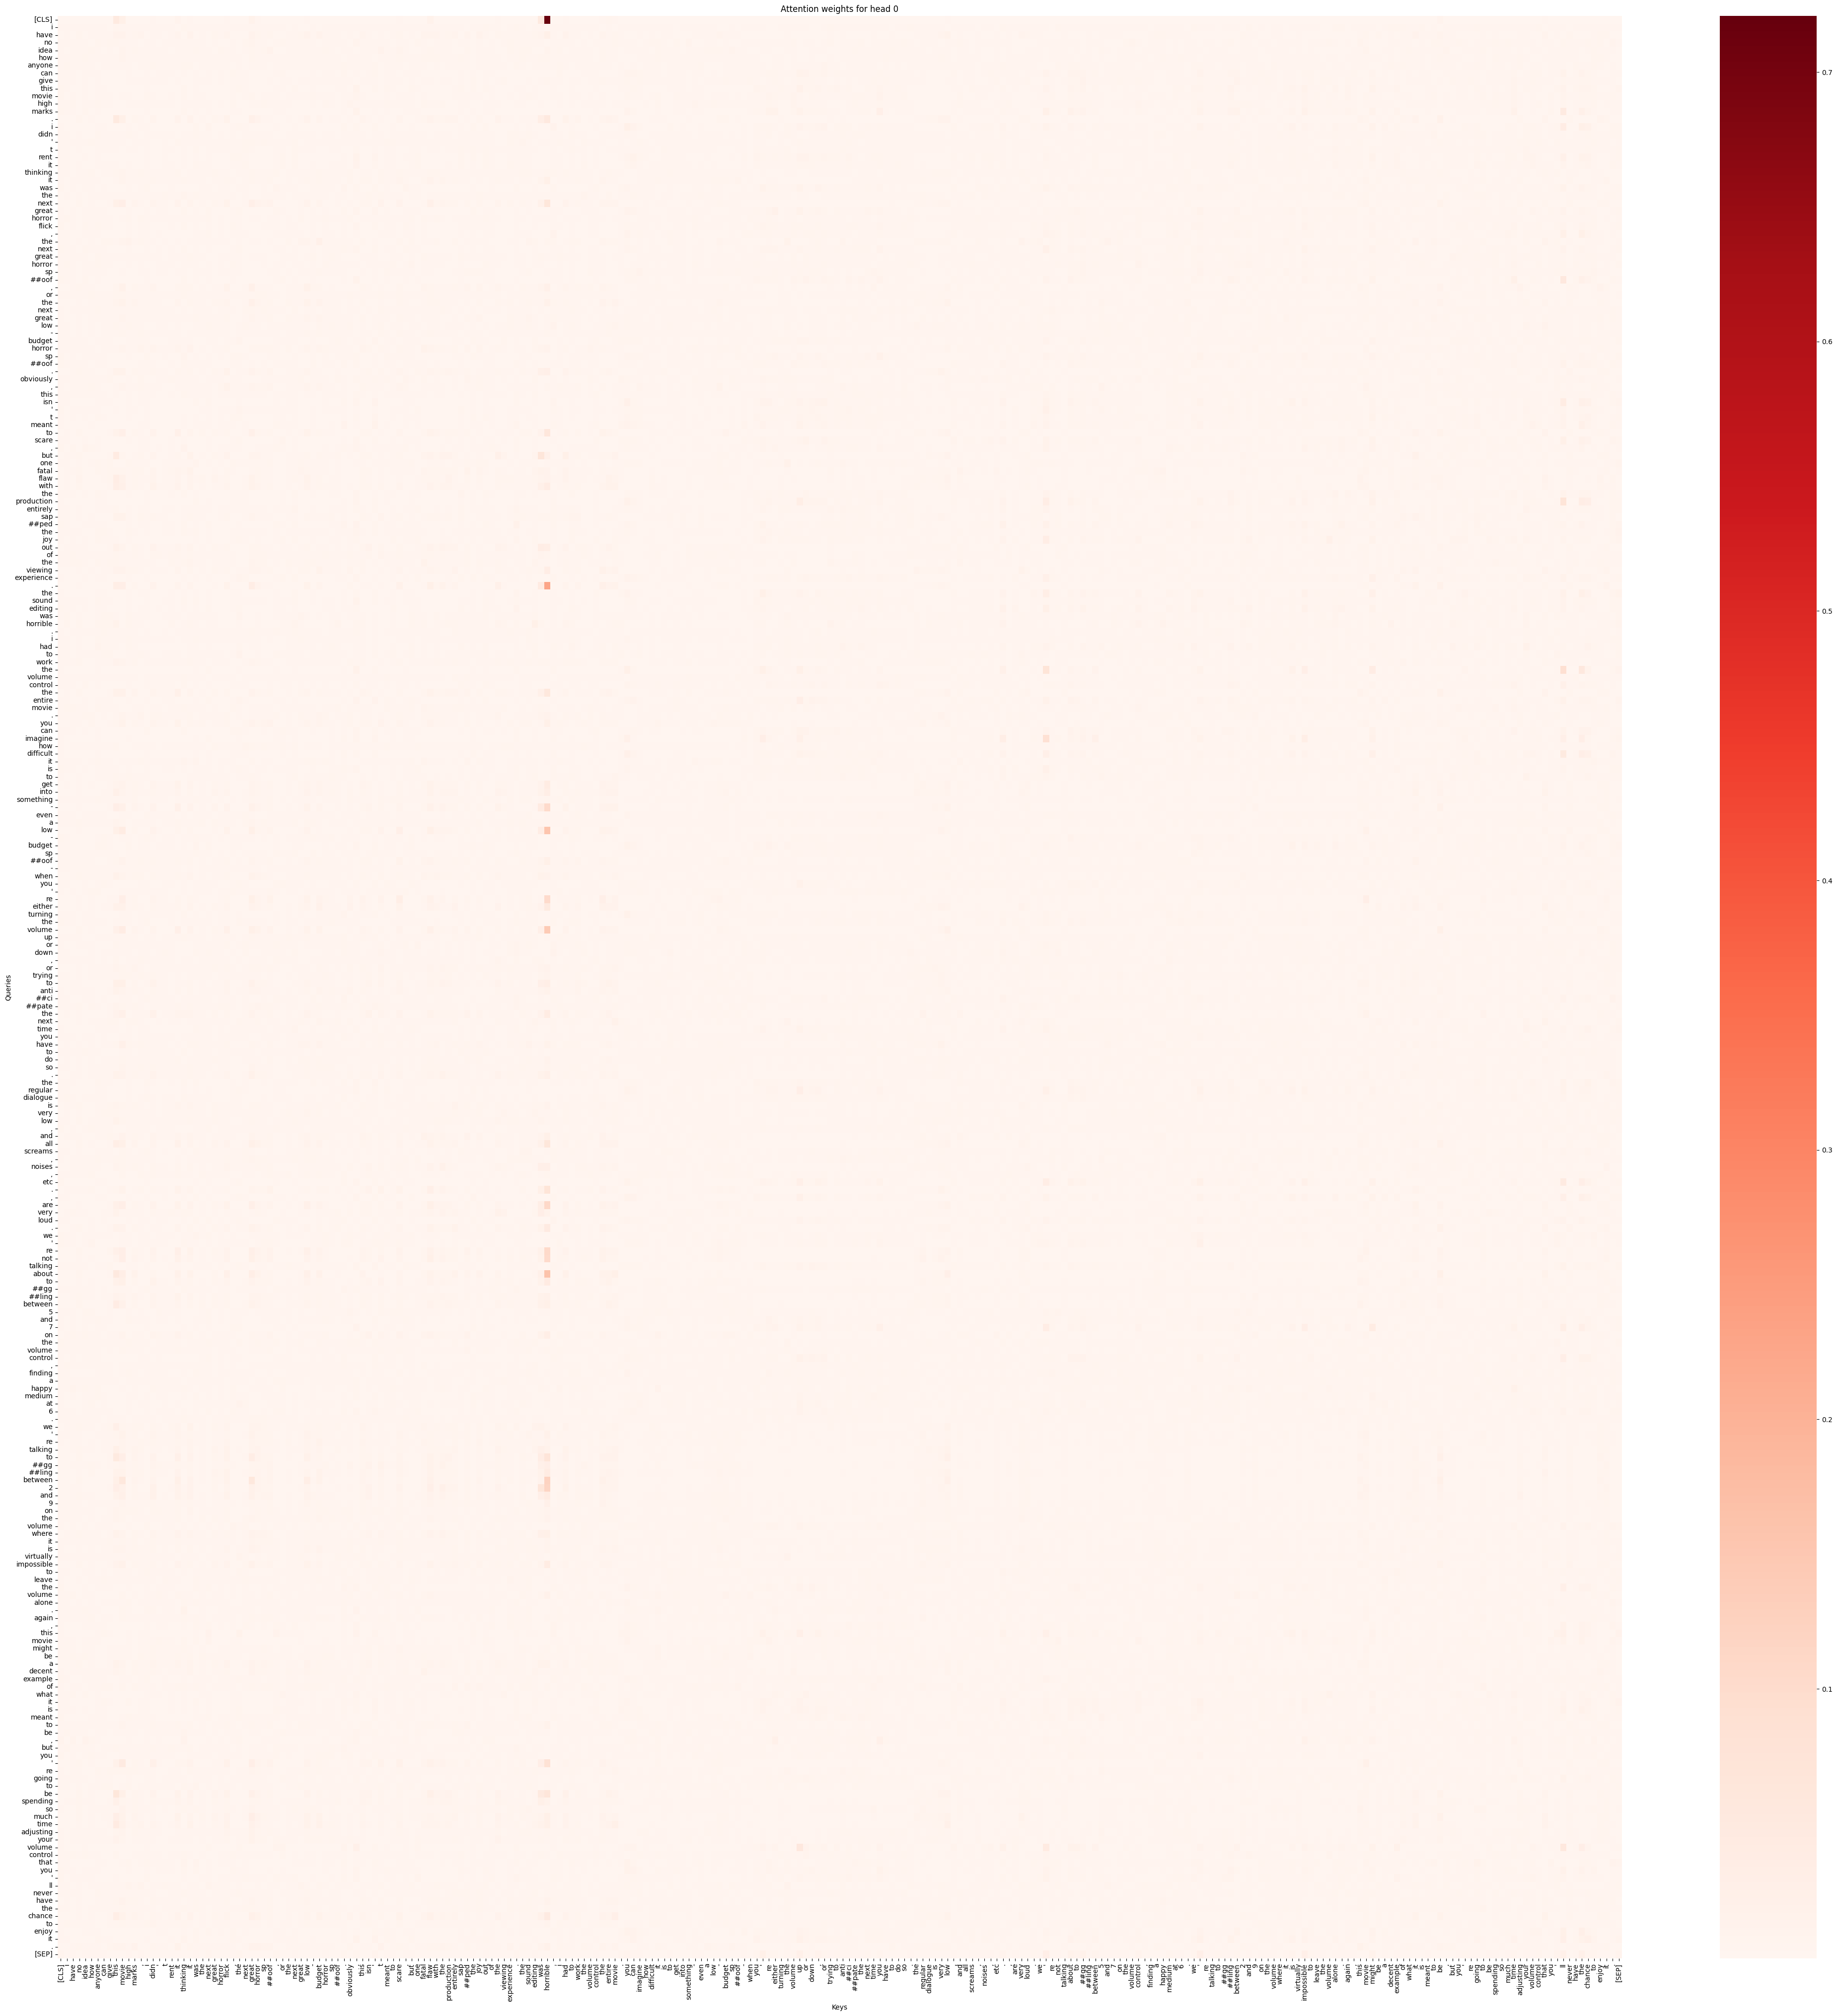

In [43]:
idx = 42
lvl_idx = 0
head_idx = 0


def input_to_tensor(_input, device):
    _input["tokens"] = tokenizer.convert_ids_to_tokens(_input["input_ids"])
    _input["input_ids"] = torch.tensor(
        _input["input_ids"], device=device, dtype=torch.long
    ).reshape(1, -1)
    _input["attention_mask"] = torch.tensor(
        _input["attention_mask"], device=device, dtype=torch.long
    ).reshape(1, -1)
    _input["label"] = torch.tensor(_input["label"], device=device).reshape(1, -1)
    return _input


input_ = input_to_tensor(imdb["test"][idx], device)

with torch.no_grad():
    pred, _ = model(input_["input_ids"], input_["attention_mask"])
    print(f"Predicted probabilities: {pred.exp()}")
    create_attention_plots(model, input_, lvl_idx=lvl_idx, head_idx=head_idx)



You can also test the model on custom inputs. Simply change the `text` to your own text. Play around to find out what makes the model think a review is positive or negative. Try out neutral reviews to see how the model is able to handle them.

Also, try changing the `lvl_idx` and `head_idx` to see how the attention weights change. For looking at the attention weight within the distilBERT model, you can set `attn_key="bert_attn"`.

Predicted probabilities: tensor([[0.8848, 0.1152]])


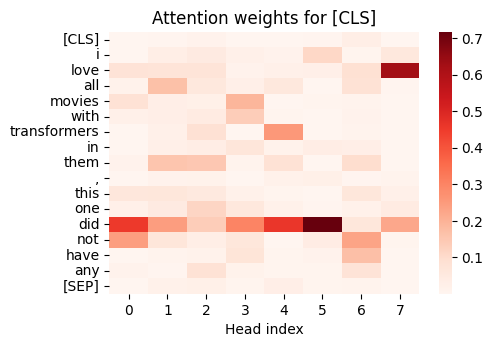

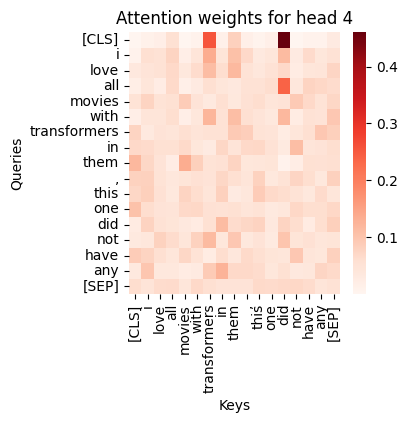

In [44]:
text = "i do not have an opinion about the movie. i spend most of my time training neural networks, but my friends say it's 'meh'."
text = "i love all movies with transformers in them, this one did not have any"
lvl_idx = 0
head_idx = 4

input_ = text_to_tensor(text, tokenizer)
# This does not really matter, but for consistency, we add a label here.
input_["label"] = [1]

input_ = input_to_tensor(input_, device)

with torch.no_grad():
    pred, _ = model(input_["input_ids"], input_["attention_mask"])
    print(f"Predicted probabilities: {pred.exp()}")
    create_attention_plots(
        model, input_, lvl_idx=lvl_idx, head_idx=head_idx, attn_key="transformer_attn"
    )


**[2 points]** The above implementation of the transformer is using multi-head self-attention. Briefly describe which parts are different in different heads of the multi-head self-attention layer.

**Your answer:** (fill in here)

**[2 points]** What are the benefits of using multi-head self-attention compared to a single-head self-attention block? 

**Your answer:** (fill in here)

**[2 points]** When applying transformers it is common to have a maximum sequence length. What problems can you foresee when applying transformers to longer sequences?

**Your answer:** (fill in here)

**[3 points]** In natural language processing, as well as other fields such as computer vision, Transformers have become extremely popular and started replacing standard models such as CNN and RNN. 

What are the main differences between a transformer and an RNN? In particular, how do the differences make it easier to train a transformer, compared to an RNN?

**Your answer:** (fill in here)

### Learned token embedding
We can also inspect the learned embeddings of the tokens for the distilBERT model. Each token is mapped to a learned vector before being processed by the Transformer. We can list the embeddings and corresponding tokens with largest cosine similarity to a given token. 

Try different words to get an intuition for how this works. Interesting examples can be "good", "four", "actor", or words with multiple meanings such as "feet" or "watch". Are the results what you'd expect?

In [45]:
import torch.nn.functional as F

word = "yes"
topk = 10
token_embeddings = model.bert.bert.embeddings.word_embeddings.weight

# The first token will be the CLS token, while the last token will be the SEP token. We ignore these tokens.
tokenized_word = tokenizer(word, truncation=True).input_ids[1:-1]
# Use mean in case word consists of multiple tokens.
word_embedding = token_embeddings[tokenized_word].mean(dim=0, keepdim=True)

similarity = F.cosine_similarity(word_embedding, token_embeddings, dim=1)
similarity = similarity.cpu()

_, idx = torch.topk(similarity, k=topk)

print(f"{topk} most similar words to {word}")
for i in range(topk):
    print(f"{i}. {tokenizer.convert_ids_to_tokens(idx[i].item())}")


10 most similar words to yes
0. yes
1. yeah
2. aye
3. yep
4. hello
5. nay
6. nodded
7. ##yes
8. 1729
9. 1734


**[2 points]** The word embeddings seem to capture the semantic meaning of the words in a sense that they are more similar to synonyms than other words in the vocabulary. If this is the case, why do we need to use advanced networks such as Transformers to process them further for classification?

**Your answer:** (fill in here)

We can also inspect the positional embeddings of the distilBERT model. Below we draw a heatmap for the cosine similarity between the learned positional embeddings. We only draw this for the first `first_k` tokens, feel free to inspect other ranges as well.

<AxesSubplot: >

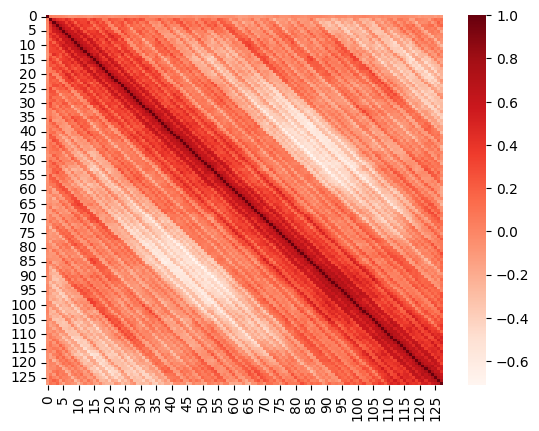

In [46]:
first_k = 128

pos_embeddings = model.bert.bert.embeddings.position_embeddings.weight
sims = pos_embeddings @ pos_embeddings.T
pos_emb_norm = torch.norm(pos_embeddings, dim=1)
sims = sims / (pos_emb_norm.unsqueeze(1) @ pos_emb_norm.unsqueeze(0))

sns.heatmap(sims.cpu().detach().numpy()[:first_k, :first_k], cmap="Reds")



**[4 points]** When training the RNN in part 1, we did not need any positional embeddings. 

Why do we need them now? What would happen if we did not use them? Also, are there any applications where you do not need them when using a Transformer (please be specific here)?

**Your answer:** (fill in here)

**[2 points]** Why do we see these particular patterns in the heatmap above?

**Your answer:** (fill in here)

**[1 point]** The first positional embedding (the one for the [CLS] token) has a different pattern than the other embeddings. Why? You can think of the implications in the Transformer if this wasn't the case.

**Your answer:** (fill in here)

# Wrapping up

The transformer architecture has become incredibly popular and has produced truly amazing results.
You should now have a good insight for how they can be implemented in `pytorch`. If you are interested, here are some more resources:

- https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
- https://github.com/huggingface/transformers